Morgan Bauer
score_prediction.ipynb
Predicts the fantasy score of an individual NBA player for one game based on the
last 10 games using an RNN.

Import required libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import csv
import pandas
from tensorflow.keras.models import load_model
from keras.optimizers import RMSprop

Define hyperparameters

In [16]:
sampling_rate = 1
sequence_length = 10
delay = sampling_rate * (sequence_length)
batch_size = 78
buffer_size = 60
epochs = 12
optimizer = RMSprop(learning_rate=0.005)

Calculate normalization constants

In [11]:
# Use to calculate mean and std dev
teams = {'ATL': '0',
         'BOS': '1',
         'BRK': '2',
         'CHO': '3',
         'CHI': '4',
         'CLE': '5',
         'DAL': '6',
         'DEN': '7',
         'DET': '8',
         'GSW': '9',
         'HOU': '10',
         'IND': '11',
         'LAC': '12',
         'LAL': '13',
         'MEM': '14',
         'MIA': '15',
         'MIL': '16',
         'MIN': '17',
         'NOP': '18',
         'NYK': '19',
         'OKC': '20',
         'ORL': '21',
         'PHI': '22',
         'PHO': '23',
         'POR': '24',
         'SAC': '25',
         'SAS': '26',
         'TOR': '27',
         'UTA': '28',
         'WAS': '29'}
         
main_dir = "/Users/morganbauer/Documents/GitHub/fantasy_basketball/rnn_score_prediction/training_data"
all_fan_pts = np.zeros(23694)
all_raw_data = np.zeros((23694, 24))
fan_pts_index = 0
raw_data_index = 0
count = 0
for sub_dir in os.listdir(main_dir):
    path = f"{main_dir}/{sub_dir}"
    try:
        for file in os.listdir(path):
            if file[:4] == '2023' or file[:4] == '2024':
                file_path = f"{path}/{file}"
                with open(file_path, "r") as infile:
                    reader = csv.reader(infile)
                    games = []
                    for row in reader:
                        try:
                            row[3] = teams[row[3]]
                            for pos, elem in enumerate(row):
                                row[pos] = float(elem)
                            games.append(row)
                        except KeyError:
                            pass
                        except IndexError:
                            pass
                if len(games) > delay + 1:
                    for i, game in enumerate(games):
                        count += 1
                        all_fan_pts[fan_pts_index] = game[1]
                        all_raw_data[raw_data_index, :] = game
                        fan_pts_index += 1
                        raw_data_index += 1
    except NotADirectoryError:
        pass

num_train_samples = 9688 #80%
num_val_samples = 1211 #10%
num_test_samples = 12111 - 9688 - 1211
print("train:", num_train_samples)
print("val:", num_val_samples)
print("test:", num_test_samples)

mean = all_raw_data[:num_train_samples].mean(axis = 0)
std_dev = all_raw_data[:num_train_samples].std(axis = 0)
print("mean", mean)
print("std dev:", std_dev)

train: 9688
val: 1211
test: 1212
mean [25.73245252 22.22775599  0.50082576 14.42898431  0.50227085  4.12665153
  8.72419488  0.44987066  1.23482659  3.41215937  0.26175867  1.77983072
  2.28003716  0.44516856  1.0347853   3.20447977  4.23926507  2.45819571
  0.7021057   0.47016928  1.33144096  1.93517754 11.26796036 23.55231386]
std dev: [ 4.42373344 14.77045631  0.49999932  8.66197699  0.49999484  3.27010706
  6.15518962  0.24711613  1.5392863   3.16761403  0.287935    2.42942028
  2.91014731  0.43337025  1.37683431  2.66018456  3.35310755  2.67556667
  0.94470782  0.85059476  1.44828065  1.46966616  8.96177527 10.67345893]


Prepare dataset

In [12]:
train_dataset = None
val_dataset = None
test_dataset = None
sample_count = 0

for sub_dir in os.listdir(main_dir):
    path = f"{main_dir}/{sub_dir}"
    try:
        for file in os.listdir(path):
            if file[:4] == '2023' or file[:4] == '2024':
                file_path = f"{path}/{file}"
                with open(file_path, "r") as infile:
                    reader = csv.reader(infile)
                    games = []
                    for row in reader:
                        try:
                            row[3] = teams[row[3]]
                            for pos, elem in enumerate(row):
                                row[pos] = float(elem)
                            games.append(row)
                        except KeyError:
                            pass
                        except IndexError:
                            pass
                if len(games) > delay + 1:
                    fan_pts = np.zeros(len(games))
                    raw_data = np.zeros((len(games), len(games[0])))
                    for i, game in enumerate(games):
                        fan_pts[i] = game[1]
                        raw_data[i, :] = game
                    # Normalizing input data
                    raw_data -= mean
                    raw_data /= std_dev
                    game_dataset = keras.utils.timeseries_dataset_from_array(
                        raw_data[:-delay],
                        targets = fan_pts[delay:],
                        sampling_rate = sampling_rate,
                        sequence_length = sequence_length,
                        shuffle = True,
                        batch_size = batch_size
                    )
                    if sample_count < 468:
                        if train_dataset is None:
                            train_dataset = game_dataset
                        else:
                            train_dataset = train_dataset.concatenate(game_dataset)
                    elif sample_count < 527:
                        if val_dataset is None:
                            val_dataset = game_dataset
                        else:
                            val_dataset = val_dataset.concatenate(game_dataset)
                    else:
                        if test_dataset is None:
                            test_dataset = game_dataset
                        else:
                            test_dataset = test_dataset.concatenate(game_dataset)
                    sample_count += 1
    except NotADirectoryError:
        pass
    if sample_count == 12111:
        break
train_dataset = train_dataset.shuffle(buffer_size = buffer_size)
val_dataset = val_dataset.shuffle(buffer_size = buffer_size)
test_dataset = test_dataset.shuffle(buffer_size = buffer_size)

In [82]:
num_samples = 0
for samples, targets in test_dataset:
    for sample in samples:
        print(sample.shape)
        num_samples += 1
print(num_samples)

(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(10, 24)
(

Building and training the net

In [17]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.GRU(256, recurrent_dropout = 0.25, return_sequences = True)(inputs)
x = layers.GRU(128, recurrent_dropout = 0.25, return_sequences = True)(x)
x = layers.GRU(64, recurrent_dropout = 0.25, return_sequences = True)(x)
x = layers.GRU(32, recurrent_dropout = 0.25)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer = optimizer, loss = "mse", metrics = ["mae"])

history = model.fit(train_dataset, epochs = epochs, validation_data = val_dataset)

Epoch 1/12
262/262 [==============================] - 34s 88ms/step - loss: 306.9594 - mae: 13.3621 - val_loss: 174.1131 - val_mae: 9.8162
Epoch 2/12
262/262 [==============================] - 26s 88ms/step - loss: 168.0708 - mae: 10.0166 - val_loss: 141.1996 - val_mae: 9.0298
Epoch 3/12
262/262 [==============================] - 25s 83ms/step - loss: 153.5704 - mae: 9.6257 - val_loss: 139.6981 - val_mae: 8.9002
Epoch 4/12
262/262 [==============================] - 25s 83ms/step - loss: 144.1972 - mae: 9.3359 - val_loss: 129.5086 - val_mae: 8.8288
Epoch 5/12
262/262 [==============================] - 24s 82ms/step - loss: 142.4530 - mae: 9.2445 - val_loss: 133.4753 - val_mae: 8.7168
Epoch 6/12
262/262 [==============================] - 24s 81ms/step - loss: 139.6941 - mae: 9.1258 - val_loss: 122.2913 - val_mae: 8.4592
Epoch 7/12
262/262 [==============================] - 24s 80ms/step - loss: 139.7888 - mae: 9.1152 - val_loss: 126.8186 - val_mae: 8.5981
Epoch 8/12
262/262 [============

Visualize training and validation metrics

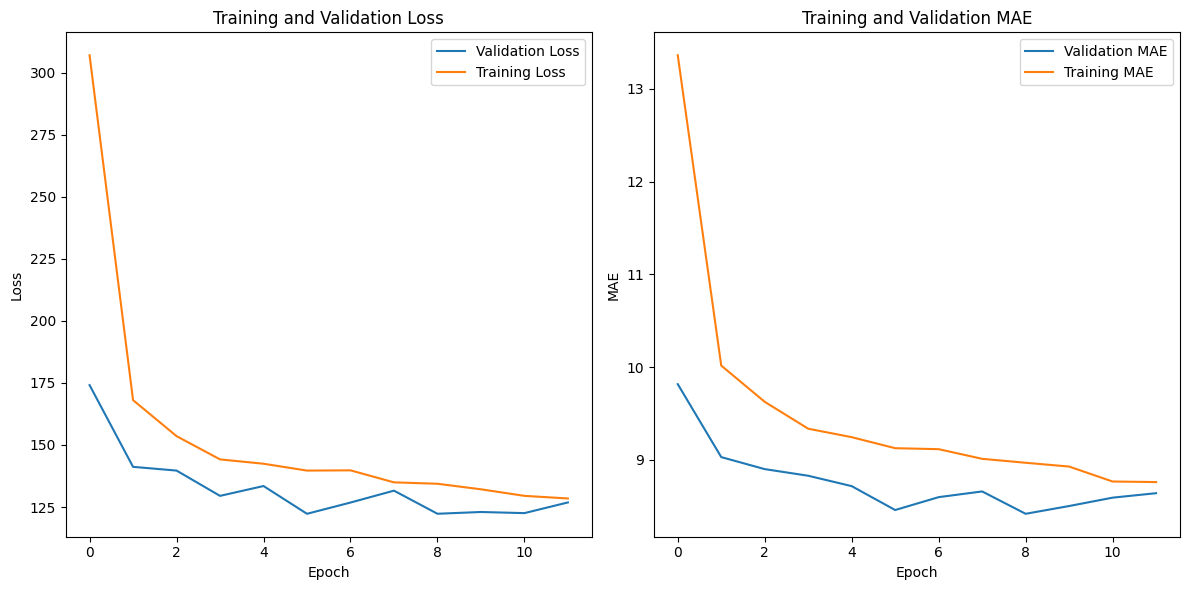

In [18]:
# Plotting the validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.plot(history.history['mae'], label='Training MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

Evaluate model

In [19]:
# Evaluate the model on the test set
evaluation_result = model.evaluate(test_dataset)

# Print the evaluation metrics
print("Test Loss:", evaluation_result[0])
print("Test Mean Absolute Error:", evaluation_result[1])

32/32 [==============================] - 4s 14ms/step - loss: 134.9980 - mae: 8.9689
Test Loss: 134.99801635742188
Test Mean Absolute Error: 8.968891143798828


Predict scores

In [21]:
new_model = load_model("/Users/morganbauer/Documents/GitHub/fantasy_basketball/rnn_score_prediction/models/basic_score_prediction.keras")

In [26]:
input_sequence = np.array([[[22, 38.10, 0, 11, 1, 10, 26, 0.385, 2, 4, 0.500, 9, 9, 1.000, 0, 3, 3, 5, 0, 1, 1, 4, 10, 38.133],
                           [22, 44.50, 1, 29, 1, 10, 22, 0.455, 2, 7, 0.286, 4, 4, 1.000, 1, 4, 5, 7, 1, 0, 1, 2, 26, 37.583],
                           [22, 28.30, 1, 13, 1, 6, 15, 0.400, 2, 4, 0.500, 1, 1, 1.000, 0, 4, 4, 5, 1, 0, 2, 1, 15, 23.450],
                           [22, 44.40, 0, 19, 1, 12, 20, 0.600, 4, 9, 0.444, 3, 4, 0.750, 0, 2, 2, 8, 2, 0, 7, 2, 31, 37.467],
                           [22, 54.10, 1, 5, 1, 8, 20, 0.400, 3, 6, 0.500, 4, 4, 1.000, 0, 8, 8, 11, 2, 0, 1, 3, 23, 37.383],
                           [22, 39.80, 1, 14, 1, 6, 14, 0.429, 1, 5, 0.200, 3, 3, 1.000, 0, 4, 4, 10, 2, 1, 5, 2, 16, 34.017],
                           [22, 33.60, 0, 21, 1, 8, 15, 0.533, 2, 6, 0.333, 3, 4, 0.750, 1, 2, 3, 6, 1, 0, 3, 1, 21, 32.150],
                           [22, 40.70, 1, 11, 1, 11, 21, 0.524, 1, 6, 0.167, 0, 0, 0.000, 0, 6, 6, 7, 1, 0, 3, 3, 23, 37.583],
                           [22, 37.70, 1, 22, 1, 5, 17, 0.294, 1, 8, 0.125, 10, 12, 0.833, 1, 5, 6, 7, 0, 0, 1, 3, 21, 30.133],
                           [22, 13.60, 0, 22, 1, 2, 9, 0.222, 0, 2, 0.000, 0, 0, 0.000, 0, 3, 3, 2, 1, 1, 3, 3, 4, 24.417]]])

input_sequence -= mean
input_sequence /= std_dev

print(f"predicted score: {new_model.predict(input_sequence)}")

1/1 [==============================] - 0s 43ms/step
predicted score: [[35.1204]]


Save model

In [20]:
model_path = "/Users/morganbauer/Documents/GitHub/fantasy_basketball/rnn_score_prediction/models/basic_score_prediction.keras"

model.save(model_path)